In [1]:
import csv
import sys
import numpy as np
import pandas as pd
import math
import networkx
import matplotlib.pyplot as plt

In [2]:
# increase field size to accomodate very high dimensional csv data
csv.field_size_limit(25000)

131072

In [3]:

def load_centroids(centroidsPath):
  centroids = []
  with open(centroidsPath, newline='') as csvfile:
      csvReader = csv.reader(csvfile, delimiter=',', quotechar='|')
      next(csvReader)
      for r in csvReader:
        row = []
        for c in r:
          row.append(float(c))
        centroids.append(row)

  centroids = np.array(centroids)
  centroids = np.delete(centroids, 0, 1) # Delete first column, which is the cluster labels
  print(centroids.shape) # Should be (10, 23579) for (clusters, genes)
  return centroids

In [5]:
originalCentroids = load_centroids('./centroids.csv')
pcaCentroids = load_centroids('./pca,kmeans_centroids.csv')
svdCentroids = load_centroids('./svd,kmeans_centroids.csv')
tsneCentroids = load_centroids('./tsne,kmeans_centroids.csv')

(10, 23579)
(9, 1)
(9, 1)
(9, 1)


In [6]:
# Converts gene labels to indices (helper function for computeDistanceSubsetGenes)
samplesPath = './samples100.csv'
samples = pd.read_csv(samplesPath)

def genes_to_index_list(genes):
    index_list = []
    for gene in genes:
        index_list += samples['Unnamed: 0'].loc[samples['Unnamed: 0'] == gene].index.tolist()
    return index_list

def index_to_gene(index):
    return samples['Unnamed: 0'][index]

In [7]:
# compute euclidean distances between cluster centroids
def computeDistance(centroids):
  distances = [[0 for _ in range(len(centroids))] for _ in range(len(centroids))]
  for i in range(len(centroids)):
    for j in range(len(centroids)):
      curDistance = 0
      for gene in range(len(centroids[0])):
        curDistance += (centroids[i][gene] - centroids[j][gene])**2
      distance = math.sqrt(curDistance)
      distances[i][j] = distance
      distances[j][i] = distance
  return distances

# alternative distance function that uses a subset of the genes
def computeDistanceSubsetGenes(centroids, genes):
  index_list = genes_to_index_list(genes)
  distances = [[0 for _ in range(len(centroids))] for _ in range(len(centroids))]
  for i in range(len(centroids)):
    for j in range(len(centroids)):
      curDistance = 0
      for gene in range(len(centroids[0])):
        if gene in index_list:
          curDistance += (centroids[i][gene] - centroids[j][gene])**2
      distance = math.sqrt(curDistance)
      distances[i][j] = distance
      distances[j][i] = distance
  return distances

# alternative distance function that weights a subset of the genes
# genes_weighed should be a dict with gene names as keys and weights as values
def computeDistanceSubsetGenesWeighted(centroids, genes_weighted):
  genes = genes_weighted.keys()
  index_list = genes_to_index_list(genes)
  distances = [[0 for _ in range(len(centroids))] for _ in range(len(centroids))]
  for i in range(len(centroids)):
    for j in range(len(centroids)):
      curDistance = 0
      for gene in range(len(centroids[0])):
        if gene in index_list:
          weight = genes_weighted[index_to_gene(gene)]
          curDistance += (weight*(centroids[i][gene] - centroids[j][gene]))**2
        else:
          curDistance += (centroids[i][gene] - centroids[j][gene])**2
      distance = math.sqrt(curDistance)
      distances[i][j] = distance
      distances[j][i] = distance
  return distances

transition_genes = {'0610009D07Rik,chr12',
 '0610010K14Rik,chr11',
 '0610012G03Rik,chr16',
 '1110038B12Rik,chr17',
 '1500012F01Rik,chr2',
 '2010107E04Rik,chr12',
 '2410004N09Rik,chr18'}
transition_genes_weighted = {gene: 10 for gene in transition_genes}

euclidOrig = computeDistance(originalCentroids)
subsetOrig = computeDistanceSubsetGenes(originalCentroids, transition_genes)
weightedOrig = computeDistanceSubsetGenesWeighted(originalCentroids, transition_genes_weighted)

euclidPCA = computeDistance(pcaCentroids)
subsetPCA = computeDistanceSubsetGenes(pcaCentroids, transition_genes)
weightedPCA = computeDistanceSubsetGenesWeighted(pcaCentroids, transition_genes_weighted)

euclidSVD = computeDistance(svdCentroids)
subsetSVD = computeDistanceSubsetGenes(svdCentroids, transition_genes)
weightedSVD = computeDistanceSubsetGenesWeighted(svdCentroids, transition_genes_weighted)

euclidTSNE = computeDistance(tsneCentroids)
subsetTSNE = computeDistanceSubsetGenes(tsneCentroids, transition_genes)
weightedTSNE = computeDistanceSubsetGenesWeighted(tsneCentroids, transition_genes_weighted)

centDistPairs = [(originalCentroids, euclidOrig), (originalCentroids, subsetOrig), (originalCentroids, weightedOrig),
(pcaCentroids, euclidPCA), (pcaCentroids, subsetPCA), (pcaCentroids, weightedPCA),
(svdCentroids, euclidSVD), (svdCentroids, subsetSVD), (svdCentroids, weightedSVD),
(tsneCentroids, euclidTSNE), (tsneCentroids, subsetTSNE), (tsneCentroids, weightedTSNE)]


In [8]:
# create graph
def createGraph(centroids, distances):
  V = set(range(len(centroids)))
  E = set()
  for i in range(len(distances)):
    for j in range(i, len(distances)):
      dist = distances[i][j]
      if dist != 0:
        E.add((dist, i, j))
  return V,E

In [10]:
def kruskals(V, E):
  MST = set()
  unionFind = {}
  setCounts = [0 for _ in range(len(V))]

  for vertex in V:
    unionFind[vertex] = vertex
    setCounts[vertex] = 1

  sortedEdges = sorted(E)
  for (dist, v1, v2) in sortedEdges:

    # check if added edge creates a cycle
    set1, set2 = unionFind[v1], unionFind[v2]
    if set1 != set2:
      
      # add to current MST
      MST.add((dist,v1,v2))

      # Merge unionFind sets after adding edge
      if setCounts[v1] < setCounts[v2]:
        setCounts[v2] += setCounts[v1]
        setCounts[v1] = 0
        for u in unionFind:
          if unionFind[u] == set1:
            unionFind[u] = set2
      else:
        setCounts[v1] += setCounts[v2]
        setCounts[v2] = 0
        for u in unionFind:
          if unionFind[u] == set2:
            unionFind[u] = set1

  return MST

# MST = kruskals(V, E)
# print(len(MST), MST)

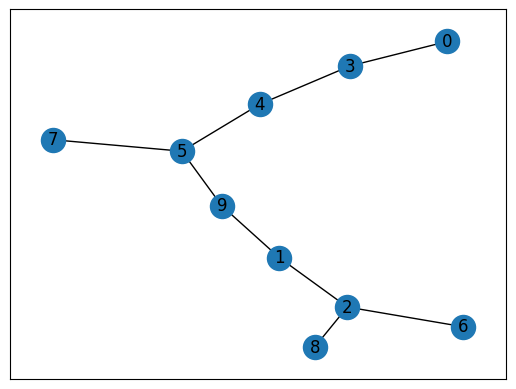

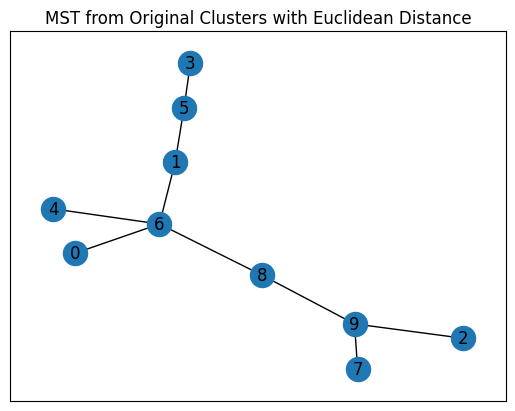

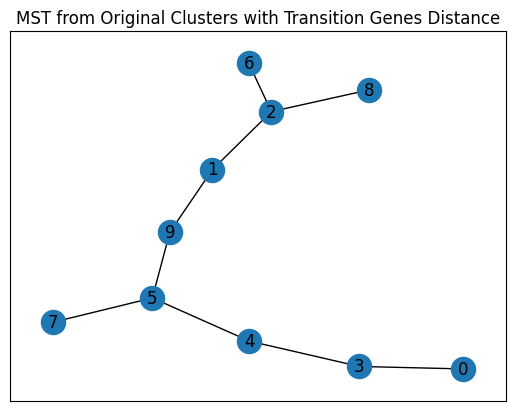

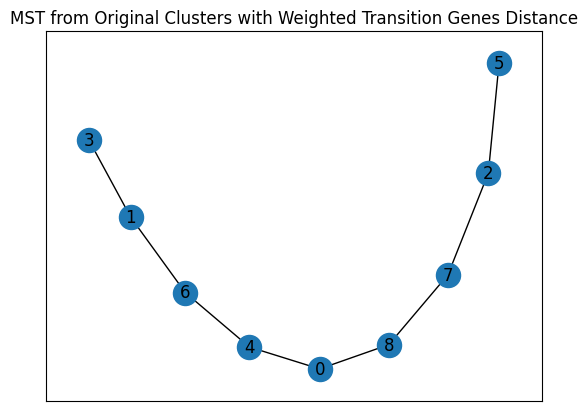

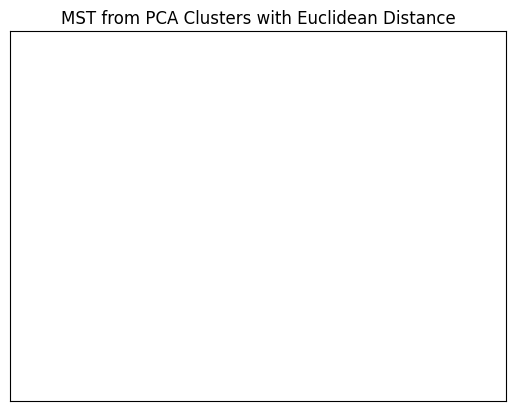

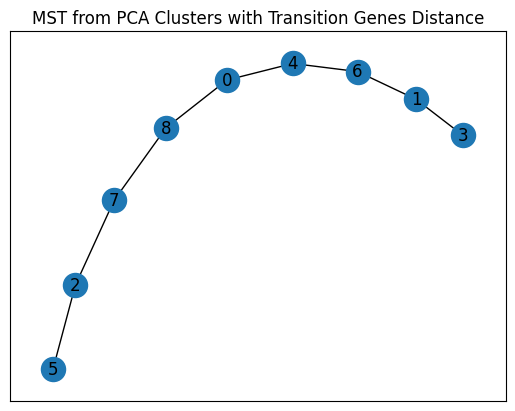

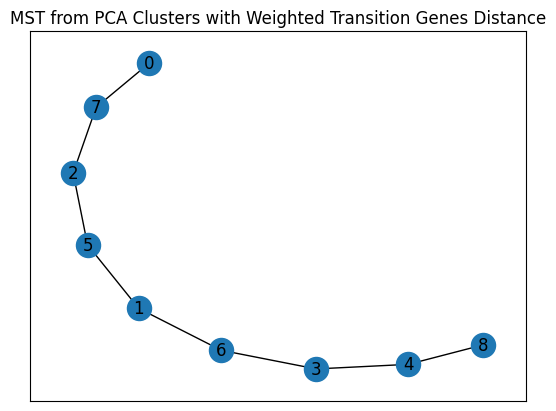

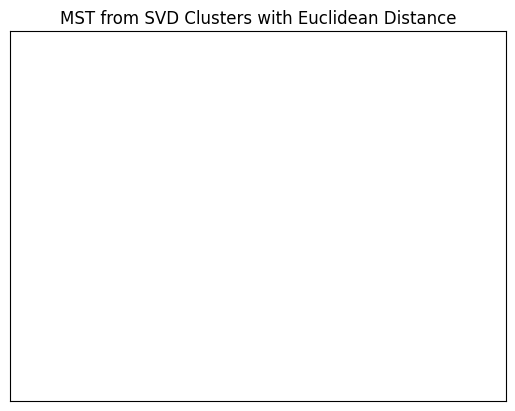

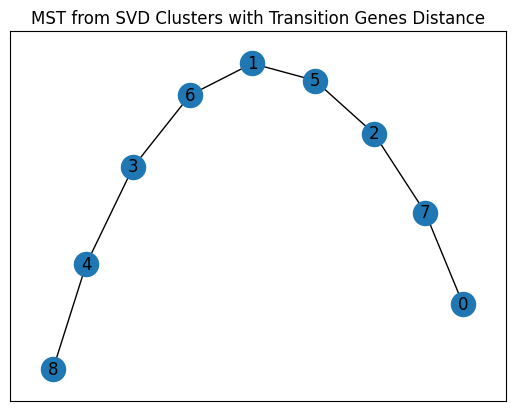

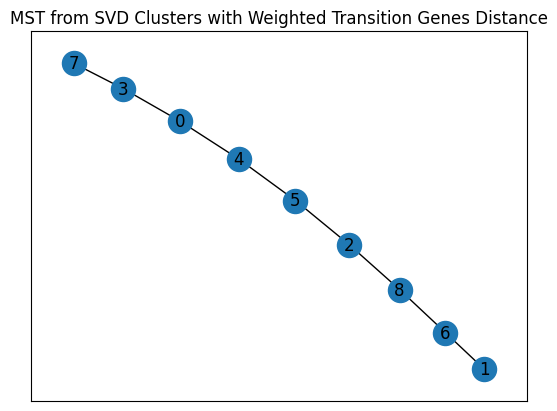

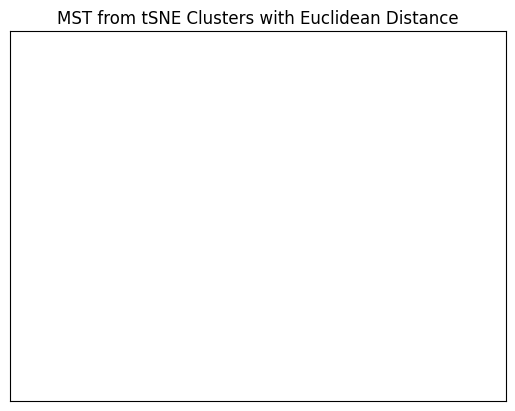

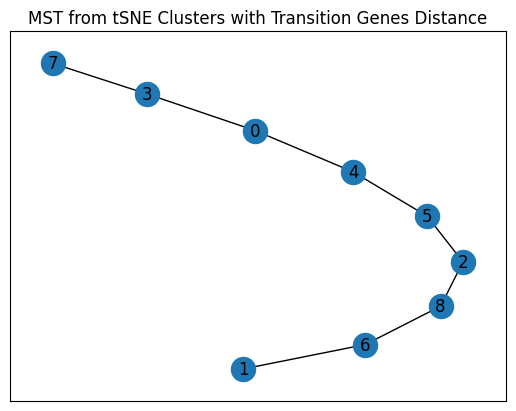

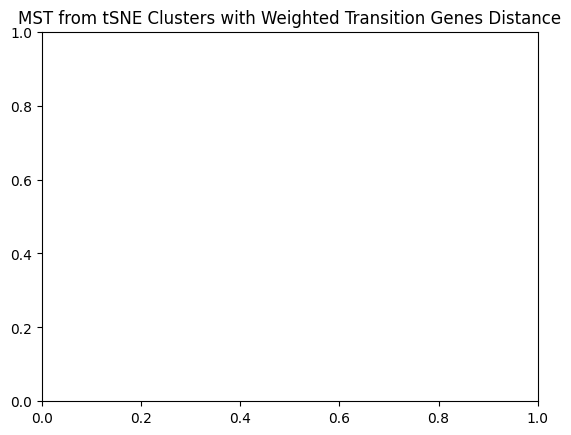

In [11]:
labels = ["MST from Original Clusters with Euclidean Distance", 
          "MST from Original Clusters with Transition Genes Distance",
          "MST from Original Clusters with Weighted Transition Genes Distance",
          "MST from PCA Clusters with Euclidean Distance", 
          "MST from PCA Clusters with Transition Genes Distance",
          "MST from PCA Clusters with Weighted Transition Genes Distance",
          "MST from SVD Clusters with Euclidean Distance", 
          "MST from SVD Clusters with Transition Genes Distance",
          "MST from SVD Clusters with Weighted Transition Genes Distance",
          "MST from tSNE Clusters with Euclidean Distance", 
          "MST from tSNE Clusters with Transition Genes Distance",
          "MST from tSNE Clusters with Weighted Transition Genes Distance"]

for i in range(len(centDistPairs)):

    (centroids, distances) = centDistPairs[i]
    
    V,E = createGraph(centroids,distances)
    MST = kruskals(V,E)

    # visualize graph
    MSTEdges = [(i,j) for (dist,i,j) in MST]

    G = networkx.Graph()
    G.add_edges_from(MSTEdges)
    networkx.draw_networkx(G)
    plt.show()
    plt.title(labels[i])
    plt.savefig(labels[i] + ".jpg")